In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the RiverAtlas Shapefile
shapefile_path = "../data/Transcend_project/HeadBasin.shp"

df = gpd.read_file(shapefile_path)
df.head()

,ObjID,BasinID,Name,NumCells,Area_KM2,PourPtLon,PourPtLat,HeadFPtLon,HeadFPtLat,lDrawRiver,RiverID,lRiverEnd,InflowLon,InflowLat,MinElev,MaxElev,AvgElev,geometry
0,2,1,Altiplano,1084,222.907,-69.997917,-17.14375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4406,5526,4683,"POLYGON ((-69.99583 -17.14167, -69.99583 -17.1..."


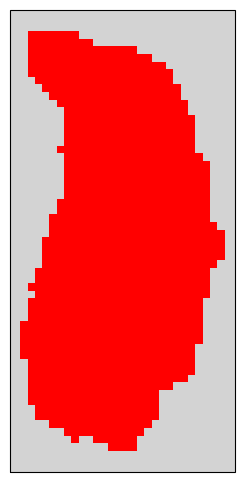

In [16]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and subplot
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Add land and ocean background
ax.add_feature(cfeature.LAND, facecolor='lightgray')

# Plot the RiverAtlas data
df.plot(ax=ax)
# Plot the RiverAtlas data
df.plot(color='red',ax=ax)

# Display the plot
plt.show()

In [23]:
df.geometry.values

<GeometryArray>
[<POLYGON ((-69.996 -17.142, -69.996 -17.146, -69.996 -17.15, -70 -17.15, -70...>]
Length: 1, dtype: geometry

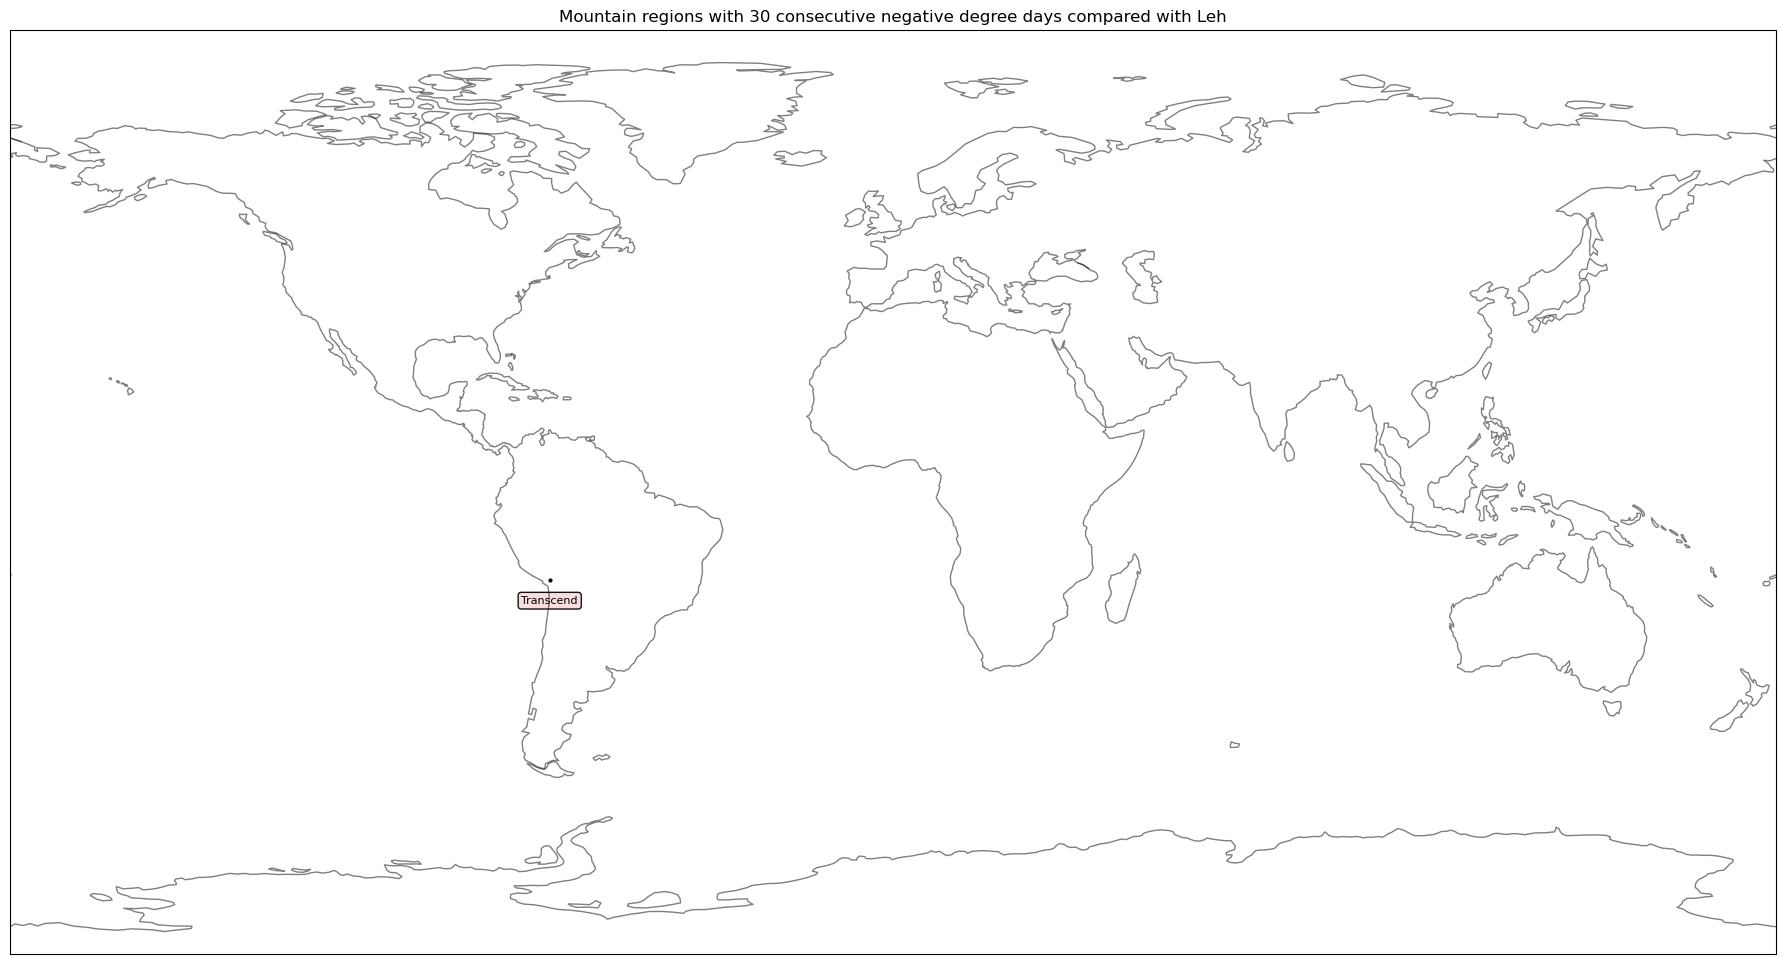

In [30]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Load the netCDF file
dataset = xr.open_dataset('../output/mt+dis+temp+ndd.nc')
var = 'normalized_ndd'

# Extract the necessary variables
lat = dataset['lat']
lon = dataset['lon']
temperature = dataset['wet_temperature']
nndd = dataset[var]

# Set the window size
window_size = 30

# Define the threshold range
thresholds = np.arange(-2, -3, -1)

# Replace NDD values of 0 with NaN
nndd_masked = nndd.where(nndd != 0, np.nan)

# Set up the map projection
projection = ccrs.PlateCarree()

# Create a figure and axis
fig, ax = plt.subplots(subplot_kw={'projection': projection}, figsize=(24,12))

# Iterate over each threshold and plot filled contour regions
for i in range(len(thresholds)):
    threshold = thresholds[i]
    mask = temperature < threshold
    
    # Apply consecutive days condition
    consecutive_days = np.zeros_like(mask, dtype=int)
    consecutive_days[0] = mask[0].astype(int)
    
    for t in range(1, len(mask)):
        consecutive_days[t] = mask[t].astype(int) * (consecutive_days[t-1] + 1)
    
    mask_consecutive = consecutive_days >= window_size
    
    mask_2d = np.any(mask_consecutive, axis=0)
    
    #ax.contourf(lon, lat, mask_2d, colors=['lightgray', 'none'], transform=ccrs.PlateCarree(), zorder=2)


# Plot nndd with the viridis colormap and color limits
cmap = plt.cm.viridis
cmap.set_bad('lightgray')  # Set grey color for masked (invalid) values
norm = plt.Normalize(vmin=0, vmax=nndd.max().values)
#nndd_masked.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
df.plot(color='red',ax=ax, zorder=5)

# Add map features
# Add country outlines
#ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', zorder=4)
ax.coastlines(zorder=5, alpha=0.5)
#ax.gridlines(zorder=5, alpha=0.3)
#ax.add_feature(cfeature.OCEAN, facecolor='lightblue', zorder=4)
ax.set_global()

# Add a place marker for Leh
transcend_coords = (-17.14375, -69.997917)
ax.plot(transcend_coords[1], transcend_coords[0], marker='o', markersize=2, color='black', transform=ccrs.PlateCarree(), zorder=5)
# annotations, with some random placement to avoid overlap
ax.text(transcend_coords[1], transcend_coords[0]-5,'Transcend', {'color': 'k', 'fontsize': 8},
                 horizontalalignment='center', verticalalignment='bottom',
                 clip_on=False,transform=ccrs.PlateCarree(),bbox=dict(boxstyle="round",
                   ec='#121212', fc='#fadede'))

# Set title and show the plot
plt.title('Mountain regions with ' + str(window_size) + ' consecutive negative degree days compared with Leh')
# Save the figure
plt.savefig("../figs/transcend_layer.png", bbox_inches="tight", dpi=300)
plt.show()